# Setup and Dowload Datasets

In [5]:
# base URL for the raw files from github
BASE_URL = "https://raw.githubusercontent.com/ck-cap/xai-series/refs/heads/master/"

# Download the utils script
!curl -sSO {BASE_URL}utils.py

# Download the Task 1 script (EDA)
!curl -sSO {BASE_URL}00_data_exploration.py

# Download dataset and put under /data folder
!mkdir -p data
!curl -sSL -o data/stroke-prediction-dataset.zip https://www.kaggle.com/api/v1/datasets/download/fedesoriano/stroke-prediction-dataset

# Unzip the datasets then remove the zip files
!unzip -o data/stroke-prediction-dataset.zip -d data
!rm data/*.zip

# list the files to check is everything is downloaded
!ls -lR


Archive:  data/stroke-prediction-dataset.zip
  inflating: data/healthcare-dataset-stroke-data.csv  
.:
total 24
-rw-r--r-- 1 root root  485 Nov 21 08:56 00_data_exploration.py
-rw-r--r-- 1 root root 1514 Nov 21 08:52 03_shap.py
drwxr-xr-x 2 root root 4096 Nov 21 08:56 data
drwxr-xr-x 2 root root 4096 Nov 21 08:53 __pycache__
drwxr-xr-x 1 root root 4096 Nov 17 14:29 sample_data
-rw-r--r-- 1 root root 1969 Nov 21 08:56 utils.py

./data:
total 312
-rw-r--r-- 1 root root 316971 Jan 26  2021 healthcare-dataset-stroke-data.csv

./__pycache__:
total 4
-rw-r--r-- 1 root root 2880 Nov 21 08:53 utils.cpython-312.pyc

./sample_data:
total 55504
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Nov 17 14:29 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Nov 17 14:29 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Nov 17 14:29 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Nov 17 14:29 mnist_train_small.csv
-rwxr-xr-x 1 root root   

# Task 1 - Exploratory Data Analysis

(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
col:  id


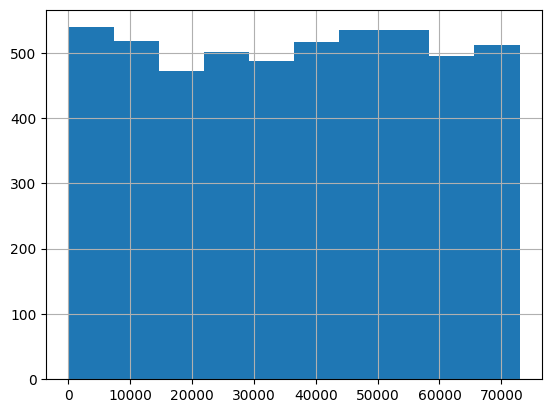

col:  gender


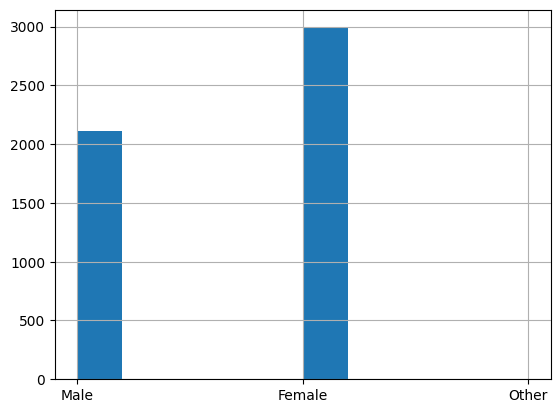

col:  age


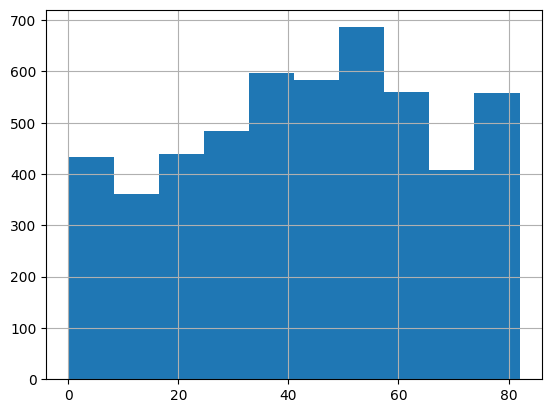

col:  hypertension


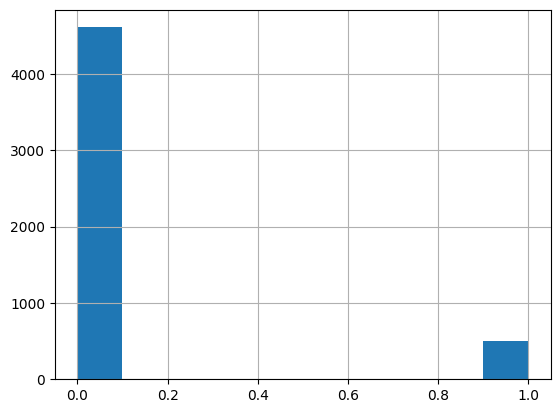

col:  heart_disease


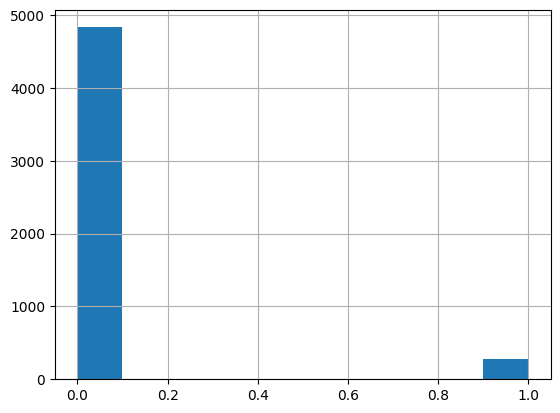

col:  ever_married


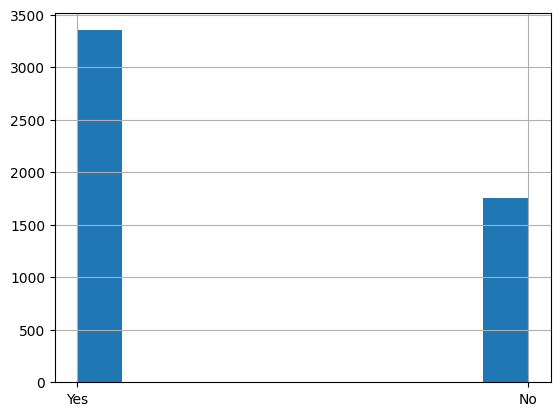

col:  work_type


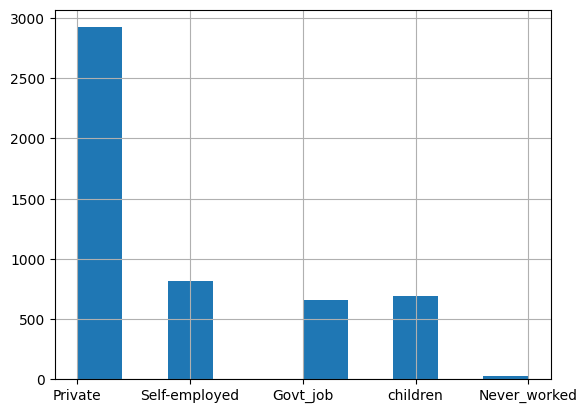

col:  Residence_type


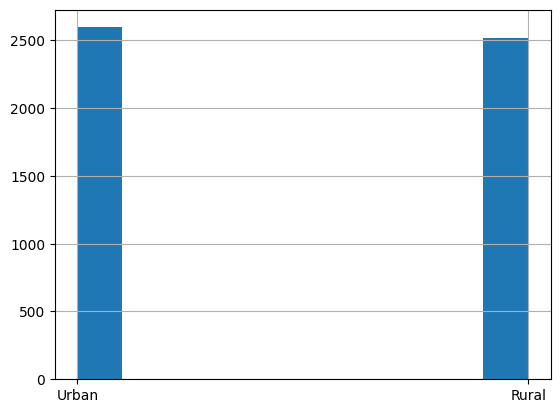

col:  avg_glucose_level


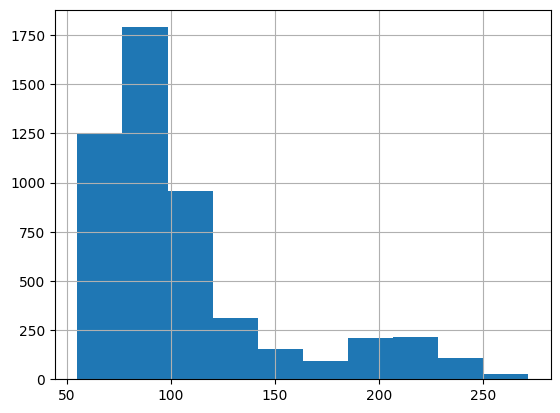

col:  bmi


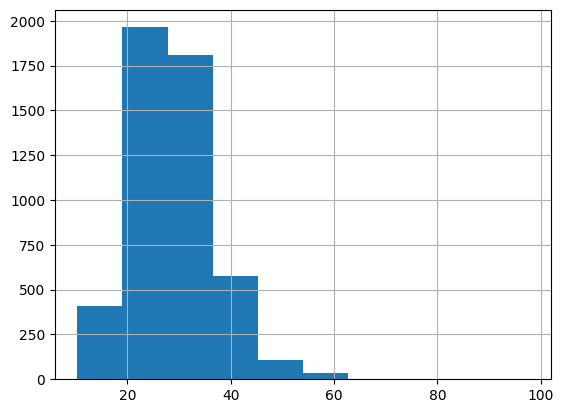

col:  smoking_status


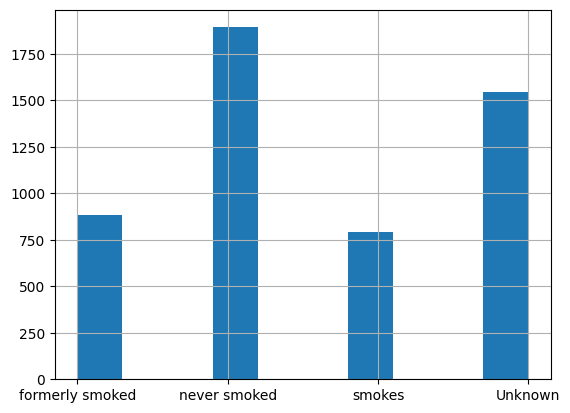

col:  stroke


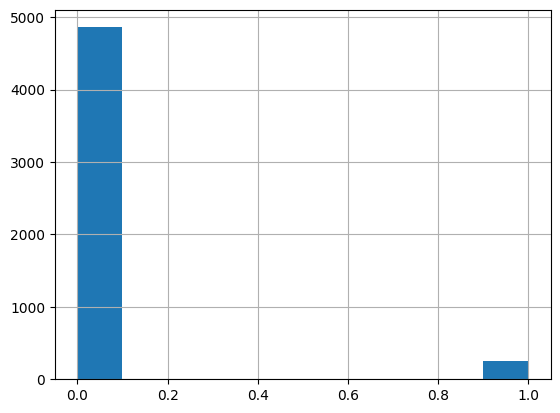

<Figure size 640x480 with 0 Axes>

In [4]:
# Task 1 - Exploratory Data Analysis
%matplotlib inline
%run 00_data_exploration.py

# Task 2 - Create XAI  explainer

In [21]:
# Imports
from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap

# 1. Load and Preprocess Data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data
X_train, X_test, y_train, y_test = data_loader.get_data_split()

# Oversample to fix imbalance
X_train, y_train = data_loader.oversample(X_train, y_train)

# 2. Fit Blackbox Model (Required before explaining)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Check accuracy just to be sure it works
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# 3. Create SHAP Explainer (THIS IS TASK 2)
# We use TreeExplainer because RandomForest is a tree-based model
explainer = shap.TreeExplainer(rf)

print("Task 2 - SHAP Explainer created.")

F1 Score 0.5302877102674878
Accuracy: 0.9412915851272016
Task 2 - SHAP Explainer created.


# Task 3 - Visualize local Explainer using Force plot

SHAP values shape: (1, 21, 2)
Shape format: [samples, features, classes]
Number of classes: 2

Prediction for sample 1:
Predicted class: 0
Probability for class 0: 0.9900
Probability for class 1: 0.0100

--- Force Plot for Class 1 (Stroke) ---


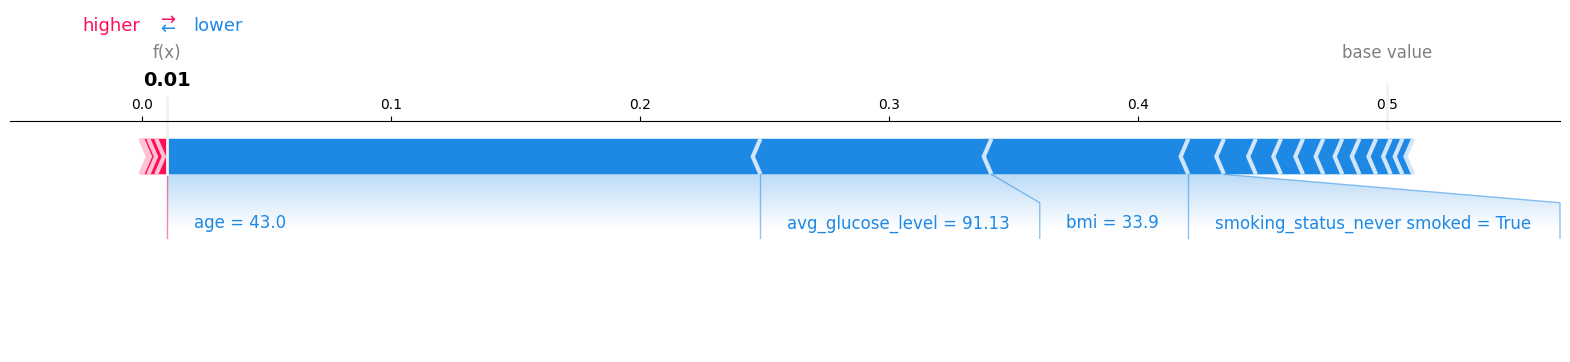

In [28]:
# Calculate SHAP values for a single patient
sample_idx = 1
sample = X_test[sample_idx:sample_idx+1]
shap_values_single = explainer(sample)

print(f"SHAP values shape: {shap_values_single.shape}")
print(f"Shape format: [samples, features, classes]")
print(f"Number of classes: {shap_values_single.values.shape[2]}")

# Visualize (Task 3)
prediction = rf.predict(sample)[0]
predicted_proba = rf.predict_proba(sample)[0]
print(f"\nPrediction for sample {sample_idx}:")
print(f"Predicted class: {prediction}")
print(f"Probability for class 0: {predicted_proba[0]:.4f}")
print(f"Probability for class 1: {predicted_proba[1]:.4f}")

# Force plot
print("\n--- Force Plot for Class 1 (Stroke) ---")
shap.plots.force(shap_values_single[0, :, 1], matplotlib=True)

# Task 4 - Visualize global Explainer using Summary plot

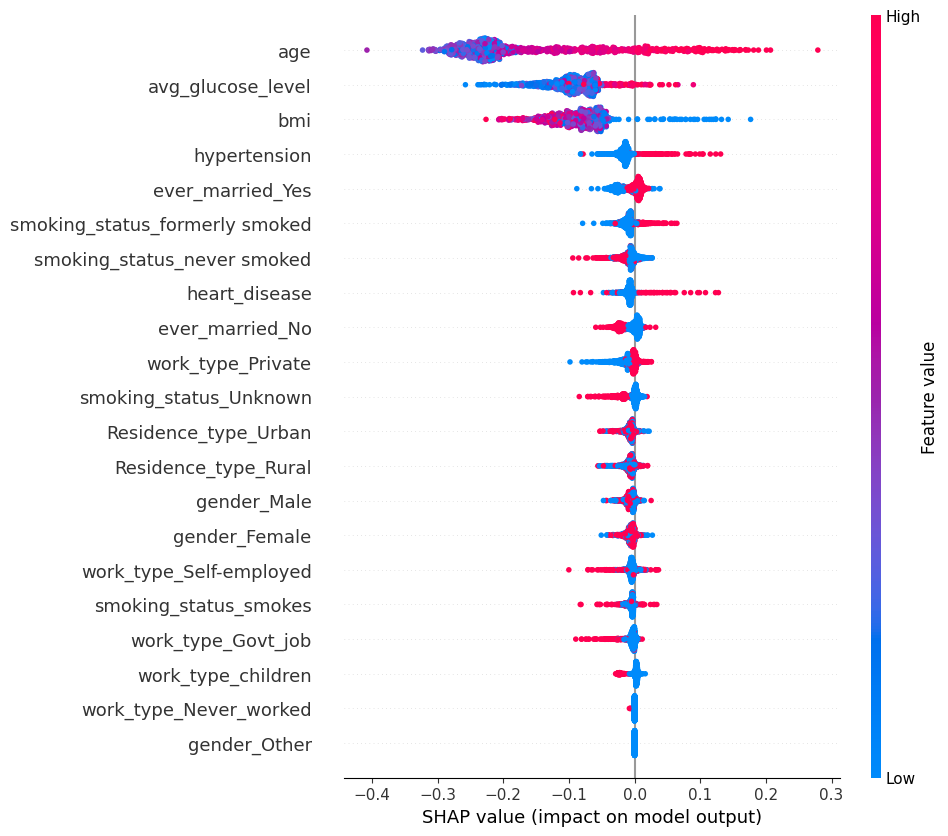

In [34]:
shap_values_all = explainer(X_test)
shap.plots.beeswarm(shap_values_all[:, :, 1], max_display=23)
